## Implementation of deterministic optimization algorithm for diagonalization

In [1]:

'''
The following code is a part of the code in the paper "Fixed depth hamiltonian simulation via Cartan decomposition". 
This code is used to deal with Pauli operations in our algorithm. 

'''

# -*- coding: utf-8 -*-
__docformat__ = 'google'
"""
Created on Mon Dec 21 15:16:56 2020
A Collection of Methods to calculate useful operations on Pauli Strings. Mostly commutators

@author: Thomas Steckmann
@author: Efekan Kokcu

"""
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
import scipy.io
from decimal import Decimal, getcontext
from joblib import Parallel, delayed
import multiprocessing as multip

ops = ['I','X','Y','Z']
"""Indices for converting from (PauliString) --> String format"""
RULES = [1,3,1,3]
"""
Used for generating the Commutator tables and pauli commutators (efficiently we think)
``
RULES:
    Used to find the multiplication between two paulis represented as indices in a tuple (I == 0, X == 1, Y == 2, Z == 3)
The operation is (index1 + index2*RULES[index1] % 4) = Pauli Matrix result as an index

I * anything: 0 + (Index2)*1 = index2
X * anythong: (1 + (Index2)*3 % 4) gives
                                         1 + 0 = 1 for I, 
                                         (1 + 1*3) % 4 = 0 for X
                                         (1 + 2*3) % 4 = 7 % 4 = 3 for Y
                                         (1 + 3*3) % 4 = 10 % 4 = 2 for Z as index2
These can easily be expanded for Y and Z
``
"""

SIGN_RULES = [[1,1,1,1], 
             [1, 1, 1j, -1j],
             [1, -1j, 1, 1j],
             [1, 1j, -1j, 1]]
"""
Rules for computing the sign of two commutators
```
SIGN_RULES: 
    Gives the multiplication sign rules for multiplying Pauli Matricies (ex. X*Y -> iZ)
    
  I  X  Y  Z
I +  +  +  +
X +  +  +i -i
Y +  -i +  +i
Z +  +i -i +

Order: row * column
```
"""

#The Pauli Matricies in matrix form
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])
paulis = [I,X,Y,Z]
#Allows for indexing the Pauli Arrays (Converting from tuple form (0,1,2,3) to string form IXYZ)

def Plist2Hmat(Plist):
    List = []
    op = ""
    for j in range(len(Plist)):
        if Plist[j] == 0:
            op += "I" 
        elif Plist[j] == 1:
            op += "X"
        elif Plist[j] == 2:
            op += "Y"
        elif Plist[j] == 3:
            op += "Z"
    List.append(op)
    #List.reverse()
    H = SparsePauliOp(List, 1)
    Hmat = Operator(H)
    return Hmat.data

def commutatePauliString(a,tupleA,b,tupleB, comm_coefs = None, comm_table = None):
    """Computes the commutator of two Pauli Strings represented as a tuple
    
    If a commutator table is passed, the operation is much more efficient

    Args:
        a (np.complex128): 
            The coefficient of the first Pauli String term
        tupleA (Tuple, integer): 
            tuple representation of the first Pauli String, or the index in the commutator table
        b (np.complex128): 
            The coefficient of the second Pauli String term
        tupleB (tuple, int): 
            tuple representation of the second Pauli String, or the index in the commutator table
        
    
    Returns:
        c (np.complex128):
            The coefficient of the result [a*TupleA,b*TupleB] = c*TupleC, where c is the Structure Constant * a * b
        tupleC (tuple): 
            the elementwise commutator of the PauliString, ignoring coefficients. 
    """
    
    if type(tupleA)==tuple:
    
        sites = len(tupleA)
        #builds up the result Tuple C
        tupleC = ()

        signForward = 1 # sign(a.b)
        signBackward = 1 # sign(b.a) 


        #Iterate elementwise over the tuple
        for i in range(sites):
            #tupleC is the tuple representation of the result of the commutator 
            tupleC += (((tupleA[i] + tupleB[i]*RULES[tupleA[i]]) % 4),)
            #Complex integer product of all the elementwise multiplications going forward
            signForward = signForward * SIGN_RULES[tupleA[i]][tupleB[i]]
            #Complex integer product of all the elementwise multiplications going backward
            signBackward = signBackward * SIGN_RULES[tupleB[i]][tupleA[i]]

        #Checks the signs forward and backwards. If they are the same, it commutes
        if signForward == signBackward:
            return (0,tupleC)
        else:
            c = a * b * 2*signForward
            return c, tupleC
    
    else:
        return (a*b*comm_coefs[int(tupleA)][int(tupleB)]), comm_table[int(tupleA)][int(tupleB)] 
    
    
    

def multiplyPauliString(a,tupleA,b,tupleB):
    """Computes the multiplication of two Pauli Strings represented as a tuple

    Args:
        a (np.complex128): 
            The coefficient of the first Pauli String term
        tupleA (Tuple):
            tuple representation of the first Pauli String
        b (np.complex128):
            The coefficient of the second Pauli String term
        tupleB (Tuple): 
            tuple representation of the second Pauli String

    Returns:
        c (np.complex128):
            The coefficient of the result a*TupleA . b*TupleB = c*TupleC, where c (the sign of the product of Paulis * a * b)
        tupleC (tuple) :
            the elementwise product of the PauliString, ignoring coefficients. 
    """
      
    sites = len(tupleA)
    #builds up the result Tuple C
    tupleC = ()
    sign = 1 # sign(a.b)
    
    #Iterate elementwise over the tuple
    for i in range(sites):
        #tupleC is the tuple representation of the result of the commutator 
        tupleC += (((tupleA[i] + tupleB[i]*RULES[tupleA[i]]) % 4),)
        #Complex integer product of all the elementwise multiplications
        sign = sign * SIGN_RULES[tupleA[i]][tupleB[i]]
        
    c = a * b * sign
    return c, tupleC  



def multiplyLinComb(A,tuplesA,B,tuplesB):
    '''Returns multiplication of two linear combinations of Pauli terms 
    '''

    a = len(A)
    b = len(B)
    
    C = []
    tuplesC = []
    csize = 0
    
    for i in range(a):
        for j in range(b):
            term = multiplyPauliString(A[i],tuplesA[i],B[j],tuplesB[j])
            flag = 0
            for k in range(csize):
                if tuplesC[k]==term[1]:
                    flag = 1
                    C[k] = C[k]+term[0]
            if flag == 0:
                C.append(term[0])
                tuplesC.append(term[1])
                csize = csize + 1
    
    return C, tuplesC





def simplifyLinComb(A,tuples):
    '''Modifies the input lists
    
    Simplifies lin comb of Pauli matrices that it eats. Doesn't return anything
    Args:
        A: A list
        tuples: A list
    '''
    
    size = len(A)
    
    index = 0
    
    while index < size:
        flag = 0
        for i in range(index):
            if tuples[i]==tuples[index]:
                A[i] = A[i]+A[index]
                A.pop(index)
                tuples.pop(index)
                flag = 1
                size = size-1
                break
                
        if flag == 0:
            index = index + 1
            
def commutateLinComb(A,tuplesA,B,tuplesB,accur):
    a = len(A)
    b = len(B)
    
    C = []
    tuplesC = []
    csize = 0
    
    for i in range(a):
        for j in range(b):
            term = commutatePauliString(A[i],tuplesA[i],B[j],tuplesB[j])
            flag = 0
            for k in range(csize):
                if tuplesC[k]==term[1]:
                    flag = 1
                    C[k] = C[k]+term[0]
            if (flag == 0) & (abs(term[0])>accur):
                C.append(term[0])
                tuplesC.append(term[1])
                csize = csize + 1
    
    return C, tuplesC



def multiplyLinCombRound(A,tuplesA,B,tuplesB, accur):
    '''
    Returns multiplication of two linear combinations of Pauli terms, and rounds things that are smaller than accur to zero. 
    '''

    a = len(A)
    b = len(B)
    
    C = []
    tuplesC = []
    csize = 0
    
    for i in range(a):
        for j in range(b):
            term = multiplyPauliString(A[i],tuplesA[i],B[j],tuplesB[j])
            flag = 0
            for k in range(csize):
                if tuplesC[k]==term[1]:
                    flag = 1
                    C[k] = C[k]+term[0]
            if (flag == 0) & (abs(term[0])>accur):
                C.append(term[0])
                tuplesC.append(term[1])
                csize = csize + 1
    
    return C, tuplesC


def commutateLinCombWithoutFactorOf2(A,tuplesA,B,tuplesB,accur):
    a = len(A)
    b = len(B)
    
    C = []
    tuplesC = []
    csize = 0
    
    for i in range(a):
        for j in range(b):
            term = commutatePauliString(A[i],tuplesA[i],B[j],tuplesB[j])
            flag = 0
            for k in range(csize):
                if tuplesC[k]==term[1]:
                    flag = 1
                    C[k] = C[k]+term[0]/2
            if (flag == 0) & (abs(term[0])>accur):
                C.append(term[0]/2)
                tuplesC.append(term[1])
                csize = csize + 1
    
    return C, tuplesC


def cleancoefs(coefs, accur):
    '''Rounds coefficients that are smaller than accur to zero.
    '''
    
    for i in range(len(coefs)):
        if abs(coefs[i])<accur:
            coefs[i] = 0

In [ ]:
'''
Based upon the above code, we define functions as follows, which are used to compute the cost function value and its gradient.
For example, the function "Indfinder" helps find a Pauli string P_i for given Q,h,P_j such that P_ihP_j = Q. 
Once such P_i is found, the function "coeff" is used to the coefficient, and together our cost function is computed.

'''

def magic(numList):
    s = ''.join(map(str, numList))
    return int(s)

def Plist2ind(plist):
    x = magic(plist)
    x = str(x)
    return int(x,4)


def Indfinder(Q,h,P_j):  ## P_ihP_j = Q => P_i = QP_jh -> i = f(j)
    result = multiplyPauliString(1,P_j,1,h)
    P_i = multiplyPauliString(1,Q,1,result[1])
    return list(P_i[1])

def coeff(P_i,h,P_j):
    result = multiplyPauliString(1,P_i,1,h)
    value = result[0]
    result_1 = multiplyPauliString(1,result[1],1,P_j)
    value = value*result_1[0]
    return value

def Ind2Plist(Ind, num_q):
    result = []
    while Ind > 0:
            result.insert(0, Ind % 4)
            Ind = Ind // 4
    
    if len(result) < num_q:
        while num_q - len(result) > 0:
            result.insert(0,0)
    return result

def Ind2PlistZ(Ind, num_q):
    result = []
    while Ind > 0:
            result.insert(0, 3*(Ind % 2))
            Ind = Ind // 2
    
    if len(result) < num_q:
        while num_q - len(result) > 0:
            result.insert(0,0)
    return result


In [3]:
'''
Here we define a toy model Hamiltonian whose eigen-decomposition is expressed by a linear combination of polynomially many Paulis.
'''

num_q = 10

num_diag = 4
num_unitary = 2

Diag_basis = []
first_unitary_basis = []

index_d = np.random.choice(2**num_q, num_diag, replace=False)
index_u = np.random.choice(4**num_q-1, num_unitary, replace=False)
index_u += 1


for i in range(num_diag):
    Diag_basis.append(Ind2PlistZ(index_d[i],num_q))

for i in range(num_unitary):
    first_unitary_basis.append(Ind2Plist(index_u[i],num_q))


Diag_coeff = np.random.normal(0,1,num_diag)
first_unitary_coeff = np.random.normal(0,1,num_unitary)


def unitary_generator(uni_basis, uni_coeff):
    uni = []
    coeff = []

    identity = []
    for i in range(num_q):
        identity.append(0)
    uni.append(tuple(identity))
    coeff.append(1)
    
    for i in range(len(uni_basis)):
        uni_sin = []
        coeff_sin = []
        uni_cos = uni
        coeff_cos = [np.cos(uni_coeff[i])*coeff[k] for k in range(len(coeff))]
        for j in range(len(uni)):
            c, P = multiplyPauliString(coeff[j],uni[j],1j*np.sin(uni_coeff[i]),uni_basis[i])
            uni_sin.append(P)
            coeff_sin.append(c)
        uni_cos.extend(uni_sin)
        coeff_cos.extend(coeff_sin)
        new_uni = list(set(uni_cos))
        new_coeff = []
        for k in range(len(new_uni)):
            indexes = [j for j, x in enumerate(uni) if x == new_uni[k]]
            c = [coeff_cos[index] for index in indexes]
            new_coeff.append(sum(c))
        uni = new_uni
        coeff = new_coeff
    
    return uni, coeff

U, U_C = unitary_generator(first_unitary_basis, first_unitary_coeff)



def Ham_generator(diag_basis, diag_coeff, uni_basis, uni_coeff):
    Ham = []
    coeff = []

    for k in range(len(diag_basis)):
        for i in range(len(uni_basis)):
            for j in range(len(uni_basis)):
                c, P = multiplyPauliString(uni_coeff[i],uni_basis[i],diag_coeff[k],diag_basis[k])
                c1, P1 = multiplyPauliString(c,P,np.conjugate(uni_coeff[j]),uni_basis[j])
                Ham.append(P1)
                coeff.append(c1)

    new_Ham = list(set(Ham))
    new_coeff = []
    for i in range(len(new_Ham)):
        indexes = [j for j, x in enumerate(Ham) if x == new_Ham[i]]
        c = [coeff[index] for index in indexes]
        new_coeff.append(sum(c))
    
    return new_Ham, new_coeff

H, C = Ham_generator(Diag_basis, Diag_coeff, U, U_C)



identity = []
for i in range(num_q):
    identity.append(0)
UU = list(set(U) - set([tuple(identity)]))

'''
The following tells us how many Pauli strings are in H and U.
'''
print(len(H))
print(len(U))
#print(U,U_C)

16
4


In [105]:
'''
Reorder Paulis in the unitary defined above to facillate cost function and gradient calculations
'''

ordered_U = []

for j in range(len(U)):
    ordered_U.append(Plist2ind(U[j]))
#ordered_ind = sorted(ordered_U)
#ordered_ind = [ordered_ind.index(k) for k in ordered_U]
#print(ordered_ind)

In [106]:
'''
The function outputs a matrix from a Pauli expansion.
'''

def Mat_gen(basis,coeff):
    
    K = np.zeros((2**num_q,2**num_q),  dtype=np.complex_)
    for j in range(len(basis)):
        K += coeff[j]*Plist2Hmat(basis[j])
    return K

#U_mat = Mat_gen(U, U_C)
#print(np.linalg.norm(np.matmul(np.transpose(np.conj(U_mat)),U_mat)-np.eye(2**num_q), 'fro'))
    

In [107]:
'''
Test model input (which is defined above)
'''

Hamiltonian = H
coeffH = C
h_cartan = Diag_basis




In [108]:
'''
Here we define key functions in our algorithm, which are to compute the cost function and its gradient.
'''
not_h_cartan = [item for item in H if list(item) not in h_cartan]  

def f_p_loss_grad(x,p):
    R = x[:len(U)]
    Theta = x[len(U):]
    
    f = 0
    
    for m in range(len(Hamiltonian)):
        H_m = Hamiltonian[m]
        for j in range(len(U)):
            P_j = U[j]
            #j = Plist2ind(P_j)
            i_j = Indfinder(p,H_m,P_j)
            if tuple(i_j) in U:
                ind_i_j = Plist2ind(i_j)
                f +=  R[ordered_U.index(ind_i_j)]*R[j]*np.exp(1j*(-Theta[ordered_U.index(ind_i_j)]+Theta[j]))*coeff(i_j,H_m,P_j)*coeffH[m]
    
    f = np.real(f)
    
    grad = x*0
    
    for j in range(len(U)):
        P_j = U[j]
        #j = Plist2ind(P_j)
        value_r = 0
        value_theta = 0
        for m in range(len(Hamiltonian)):
            H_m = Hamiltonian[m]
            i_j = Indfinder(p,H_m,P_j)
            if tuple(i_j) in U:
                ind_i_j = Plist2ind(i_j)
                value_r += R[ordered_U.index(ind_i_j)]*np.exp(1j*(Theta[ordered_U.index(ind_i_j)]-Theta[j]))*coeff(P_j,H_m,i_j)*coeffH[m]
                value_theta += R[j]*value_r
        grad[j] = 4*np.real(value_r)
        grad[j+len(U)] = 4*np.imag(value_theta)
    
    grad = grad*f
    
    return f**2, grad


def constraint_loss_grad(x,P):
    R = x[:len(U)]
    Theta = x[len(U):]
    
    phi_P = 0
    
    Identity = Ind2Plist(0,num_q)
    for j in range(len(U)):
        P_j = U[j]
        #j = Plist2ind(P_j)
        j_P = Indfinder(P,Identity,P_j)
        if tuple(j_P) in U:
            ind_j_P = Plist2ind(j_P)
            phi_P += R[j]*R[ordered_U.index(ind_j_P)]*np.exp(1j*(-Theta[ordered_U.index(ind_j_P)]+Theta[j]))*coeff(j_P,Identity,P_j)
    
    phi_P = np.real(phi_P)
    grad_P = x*0
    
    for j in range(len(U)):
        P_j = U[j]
        #j = Plist2ind(P_j)
        j_P = Indfinder(P,Identity,P_j)
        if tuple(j_P) in U:
            ind_j_P = Plist2ind(j_P)
            value = 4*R[ordered_U.index(ind_j_P)]*np.exp(1j*(-Theta[ordered_U.index(ind_j_P)]+Theta[j]))*coeff(j_P,Identity,P_j)
            grad_P[j] = np.real(value)
            grad_P[j+len(U)] = -np.imag(R[j]*value)
    
    grad_P = grad_P*phi_P
    
    
    return phi_P**2, grad_P 




In [109]:
"""optimization phase"""



"""initialization of weights"""
max_cpus = int(multip.cpu_count())

for n_ex in range(10):

    initial_weights = np.zeros(2*len(U))
    for j in range(len(U_C)):
        value = U_C[j]
        initial_weights[j] = np.abs(value)  + 0.01*np.random.normal(0,1,1)
        initial_weights[j+len(U)] =  np.angle(value) + 0.01*np.random.normal(0,1,1)


    T = 5000

    cost_mat = np.empty((0,T), int)
    weight_mat = np.empty((0,T), int)
    iteration = 0
    loss = 0 
    a = 0.01

    cost = []
    Alpha = []
    weights = initial_weights
    penalty = 1

    for iteration in range(T):
        #start = time.time()
        f_value = 0
        f_grad = weights*0
        Phi_value = 0
        Phi_grad = weights*0
        F_value = 0

        results = Parallel(n_jobs=max_cpus)(delayed(f_p_loss_grad)(weights, not_h_cartan[j]) for j in range(len(not_h_cartan)))
        for j in range(len(not_h_cartan)):
            f_value += results[j][0]
            f_grad += results[j][1]
        
        results = Parallel(n_jobs=max_cpus)(delayed(constraint_loss_grad)(weights, UU[i]) for i in range(len(UU)))
        for i in range(len(UU)):
            Phi_value += results[i][0]
            Phi_grad += results[i][1]
        
    
        F_value = f_value + penalty*Phi_value
        F_grad = f_grad + penalty*Phi_grad
    
        weights += - a*F_grad
        R = weights[:len(U)]
        weights[:len(U)] = R/np.linalg.norm(R)
    
        clear_output(wait=True)
        loss = F_value
        alpha = np.log(np.linalg.norm(F_grad)**2)/np.log(loss) 
        print(alpha)#, np.linalg.norm(F_grad)**2/loss**alpha)
        print('f and Phi values:', f_value, np.sqrt(Phi_value*2**num_q))
        print('Loss and iter:',loss,iteration)#print('error:',np.linalg.norm(ans_weights - weights))
        Alpha.append(alpha)
        cost.append(loss.flatten())
    
    Alpha = np.asarray(Alpha)
    Cost = np.asarray(cost)

    filename = "cost%d.mat" % (n_ex)
    filename1 = "alpha%d.mat" % (n_ex)
    scipy.io.savemat(filename, {'cost': Cost})
    scipy.io.savemat(filename1, {'alpha': Alpha})

1.038667752539327
f and Phi values: 2.111126643095749e-09 0.00014678289717414087
Loss and iter: 2.132166895930548e-09 4999


In [ ]:
'''
This code outputs the Frobenius error between the original Hamiltonian and the one numerically after optimization.
'''

def K_output(x):
    R = x[:len(U)]
    R = R/np.linalg.norm(R)
    Theta = x[len(U):]
    
    K = np.zeros((2**num_q,2**num_q),  dtype=np.complex_)
    for j in range(len(U)):
        P_j = U[j]
        j = Plist2ind(P_j)
        K += R[ordered_U.index(j)]*np.exp(1j*Theta[ordered_U.index(j)])*Plist2Hmat(P_j)
    return K


K_result = K_output(weights)


H = np.zeros((2**num_q,2**num_q),  dtype=np.complex_)

for m in range(len(Hamiltonian)):
    H += Plist2Hmat(Hamiltonian[m])*coeffH[m]

KdHK = np.matmul(np.transpose(np.conj(K_result)), H)
KdHK = np.matmul(KdHK,K_result)




h_0 = H*0
for i in range(len(h_cartan)):
    h_0 += np.trace(np.matmul(KdHK,Plist2Hmat(h_cartan[i])))/2**num_q*Plist2Hmat(h_cartan[i])

approx_H = np.matmul(h_0, np.transpose(np.conj(K_result)))
approx_H = np.matmul(K_result, approx_H)
approx_H = (approx_H + np.transpose(np.conj(approx_H)))/2

print('Error between H and approx_H :', np.linalg.norm(H-approx_H, 'fro'))

In [2]:
'''
We load the data obtained from the above optimization, the cost function values and the alpha values.
'''
cost_mat = np.empty((0,5000), int)
alpha_mat = np.empty((0,5000), int)
Z_mat = np.empty((0,2), int)
for i in range(10):
    filename = "cost%d.mat" % (i)
    mat = scipy.io.loadmat(filename)
    X = mat['cost']
    cost_mat = np.append(cost_mat, np.transpose(X), axis = 0)
    
    filename1 = "alpha%d.mat" % (i)
    mat = scipy.io.loadmat(filename1)
    Y = mat['alpha']
    alpha_mat = np.append(alpha_mat, Y, axis = 0)

    
    filename2 = "error%d.mat" % (i)
    mat = scipy.io.loadmat(filename2)
    Z = mat['E']
    Z_mat = np.append(Z_mat, Z, axis = 0)

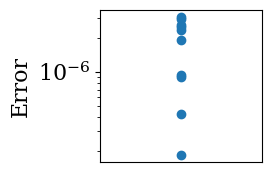

In [49]:
'''
In the folloiwng codes, we plot the data loaded above.
'''

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.io



fontsize = 16

num_p = 36

nice_fonts = {

# Use LaTeX to write all text

"text.usetex": False,

"font.family": "serif",

# Use 10pt font in plots, to match 10pt font in document

"axes.labelsize": fontsize ,

"font.size": fontsize ,

# Make the legend/label fonts a little smaller

"legend.fontsize": fontsize,

"xtick.labelsize": fontsize,

"ytick.labelsize": fontsize,

}

matplotlib.rcParams.update(nice_fonts)

#data load


rcd = Z_mat
#rcd = rcd[:,:-num_p]

mean_rcd_values = np.mean(rcd, axis=0)
std_rcd_values = np.std(rcd, axis=0)


#plot
plt.figure(figsize=(3, 2))

x1 = []
x2 = []
for i in range(len(rcd[:,0])):
    x1.append('initial')
    x2.append('final')
    
# Plot mean learning curve for GD and RCD function values
#plt.scatter(np.ones(rcd.shape[0]),rcd[:,0])
plt.scatter(np.ones(rcd.shape[0]),rcd[:,1])
# Plot shaded area for standard deviation of GD and RCD function values
#plt.fill_between(range(len(mean_rcd_values)), mean_rcd_values - std_rcd_values, mean_rcd_values + std_rcd_values, color='r', alpha=0.2)
plt.yscale('log', base=10)

#plt.xlabel('iteration')
plt.ylabel('Error')
plt.xlim(0, 2)
plt.xticks([])
#plt.grid()
plt.tight_layout()
plt.savefig('e2_16_10.jpeg')



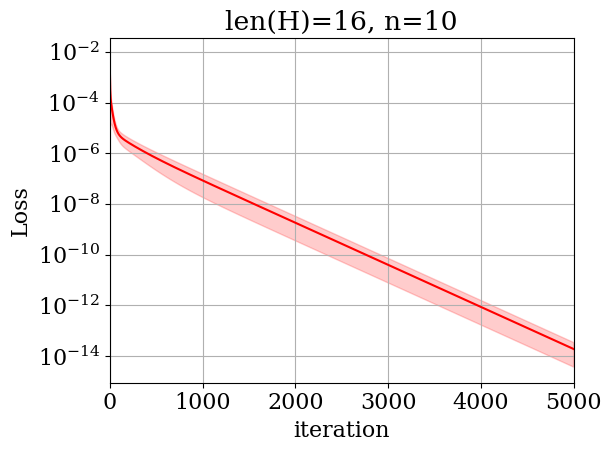

In [23]:


fontsize = 16

num_p = 36

nice_fonts = {

# Use LaTeX to write all text

"text.usetex": False,

"font.family": "serif",

# Use 10pt font in plots, to match 10pt font in document

"axes.labelsize": fontsize ,

"font.size": fontsize ,

# Make the legend/label fonts a little smaller

"legend.fontsize": fontsize,

"xtick.labelsize": fontsize,

"ytick.labelsize": fontsize,

}

matplotlib.rcParams.update(nice_fonts)

#data load


rcd = cost_mat
#rcd = rcd[:,:-num_p]

mean_rcd_values = np.mean(rcd, axis=0)
std_rcd_values = np.std(rcd, axis=0)


#plot
plt.figure()

# Plot mean learning curve for GD and RCD function values
plt.plot(mean_rcd_values, color='r', label='RCD')
plt.yscale('log', base=10)

# Plot shaded area for standard deviation of GD and RCD function values
plt.fill_between(range(len(mean_rcd_values)), mean_rcd_values - std_rcd_values, mean_rcd_values + std_rcd_values, color='r', alpha=0.2)


plt.title('len(H)=16, n=10')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.xlim(0, len(mean_rcd_values))
plt.grid()
plt.tight_layout()


#plt.axes([.65, .6, .2, .2], facecolor='w')
#plt.scatter(x1,Z_mat[:,0])
#plt.scatter(x2,Z_mat[:,1])
#plt.yscale('log', base=10)
#plt.ylim(np.min(Z_mat)*0.1, np.max(Z_mat)*1.1)
#plt.title('Error')
#plt.grid()

plt.savefig('Loss_16_10.jpeg')




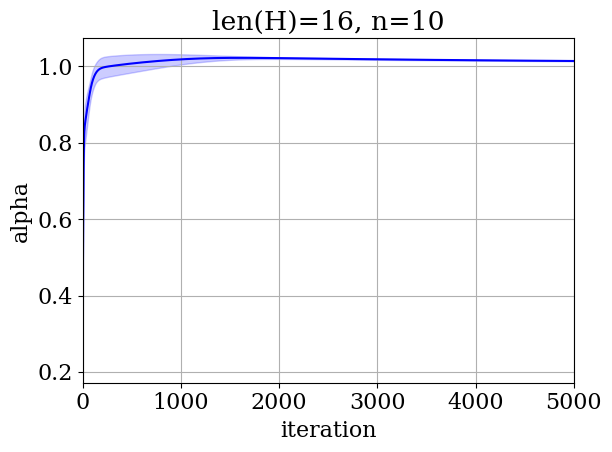

In [4]:

fontsize = 16

num_p = 36

nice_fonts = {

# Use LaTeX to write all text

"text.usetex": False,

"font.family": "serif",

# Use 10pt font in plots, to match 10pt font in document

"axes.labelsize": fontsize ,

"font.size": fontsize ,

# Make the legend/label fonts a little smaller

"legend.fontsize": fontsize,

"xtick.labelsize": fontsize,

"ytick.labelsize": fontsize,

}

matplotlib.rcParams.update(nice_fonts)

#data load

rcd = alpha_mat
#rcd = rcd[:,:-num_p]

mean_rcd_values = np.mean(rcd, axis=0)
std_rcd_values = np.std(rcd, axis=0)


#plot
plt.figure()

# Plot mean learning curve for GD and RCD function values
plt.plot(mean_rcd_values, color='b')

# Plot shaded area for standard deviation of GD and RCD function values
plt.fill_between(range(len(mean_rcd_values)), mean_rcd_values - std_rcd_values, mean_rcd_values + std_rcd_values, color='b', alpha=0.2)

plt.title('len(H)=16, n=10')
plt.xlabel('iteration')
plt.ylabel('alpha')
plt.xlim(0, len(mean_rcd_values))
plt.grid()
plt.tight_layout()
plt.savefig('alpha_16_10.pdf')


